In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from IPython import display
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from scipy import sparse

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [3]:
gamma_tree = uproot.open("/home2/chenxu/work/corsika/50GeV_1TeV_zen0.gamma.root:tCorsika")
P_tree = uproot.open("/home2/chenxu/work/corsika/100GeV_10TeV_zen0.proton.root:tCorsika")

In [4]:
gamma_prie = np.array(gamma_tree['evth/fLia[312]'].array()[:,3])
P_prie = np.array(P_tree['evth/fLia[312]'].array()[:,3])

In [5]:
gamma_secs = gamma_tree['secParticles/secParticles.fLia[8]'].array()
P_secs = P_tree['secParticles/secParticles.fLia[8]'].array()

In [6]:
secs = list()
for i in range(len(gamma_secs)):
    secs.append(gamma_secs[i])
for i in range(len(gamma_secs)):
    secs.append(P_secs[i])

In [7]:
sectype = list()
for i in range(100000):
    sectype.append(np.floor(np.array(gamma_secs[i])[:,0]/1000).astype(int))
    sectype.append(np.floor(np.array(P_secs[i])[:,0]/1000).astype(int))
sectype = np.concatenate(sectype)
sectype = list(set(sectype))

In [8]:
sectype

[1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 201, 18, 25]

In [9]:
secstype = [[1, 2, 3], [5, 6], [8, 9, 13, 14, 15, 25, 10, 11, 12, 201, 18]]

[1, 2, 3]
2.0


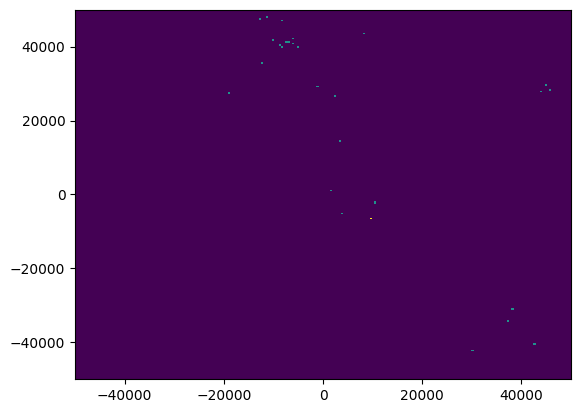

[5, 6]
1.0


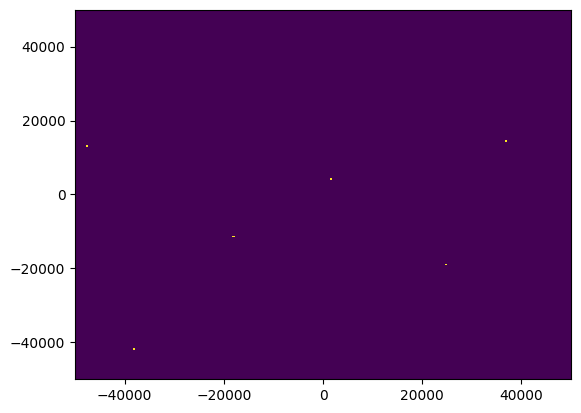

[8, 9, 13, 14, 15, 25, 10, 11, 12, 201, 18]
1.0


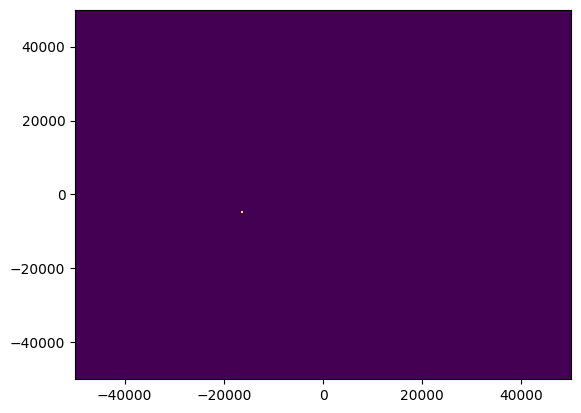

In [10]:
sec = np.array(P_secs[0])
sec=sec[:,:-1]
xbins = np.linspace(-500*100,500*100,225)
ybins = np.linspace(-500*100,500*100,225)
for i in secstype:
    print(i)
    H,_,_ = np.histogram2d(sec[:,4][np.isin((sec[:,0]/1000).astype(int),i)],sec[:,5][np.isin((sec[:,0]/1000).astype(int),i)],bins=(xbins,ybins))
    H=H.T
    print(np.max(H))
    X,Y = np.meshgrid(xbins,ybins)
    plt.pcolormesh(X, Y, H)
    plt.show()

In [11]:
gamma_log10energy = np.log10(gamma_prie).astype(np.float32)
P_log10energy = np.log10(P_prie).astype(np.float32)
log10energy = np.concatenate([gamma_log10energy, P_log10energy])

In [12]:
isgamma = np.zeros_like(log10energy,dtype=int)
isgamma[: len(gamma_log10energy)] = 1

In [13]:
class MCDataset_log10energy(Dataset):
    def __init__(self, prie, isgamma, secs):
        self.prie =  torch.from_numpy(prie)
        self.secs = secs
        self.isgamma =  torch.from_numpy(isgamma)
        self.xbins = np.linspace(-500 * 100, 500 * 100, 225)
        self.ybins = np.linspace(-500 * 100, 500 * 100, 225)
        self.secstype = [[1, 2, 3], [5, 6], [8, 9, 13, 14, 15, 25, 10, 11, 12, 201, 18]]

    def __len__(self):
        return len(self.isgamma)

    def __getitem__(self, index):
        # print(index)
        # index = [index]
        self.Matrix = np.zeros([len(self.secstype), 224, 224], dtype=np.float32)
        # print(self.secs[index])
        sec = np.array(self.secs[index]).reshape(-1, 8)
        for j, sectype in enumerate(self.secstype):
            self.Matrix[j], _, _ = np.histogram2d(
                sec[:, 4][np.isin((sec[:, 0] / 1000).astype(int), sectype)],
                sec[:, 5][np.isin((sec[:, 0] / 1000).astype(int), sectype)],
                bins=(self.xbins, self.ybins),
            )
        return (
            torch.from_numpy(self.Matrix),
            self.prie[index],
            self.isgamma[index],
        )

In [14]:
train_index, test_index = train_test_split(
    range(len(isgamma)), random_state=42, test_size=0.3
)

In [15]:
secs = np.array(secs)
MCdataset_train = MCDataset_log10energy(
    log10energy[train_index], isgamma[train_index], secs[train_index]
)
MCdataset_test = MCDataset_log10energy(
    log10energy[test_index], isgamma[test_index], secs[test_index]
)

/tmp/ipykernel_700835/2869485299.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  secs = np.array(secs)


In [16]:
MCdataset_train_dataloader = DataLoader(MCdataset_train, batch_size=256, shuffle=True)
MCdataset_test_dataloader = DataLoader(MCdataset_test, batch_size=256, shuffle=True)

In [17]:
for i in MCdataset_train_dataloader:
    print(i[0].shape)
    break

torch.Size([256, 3, 224, 224])


In [18]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            input_channels, num_channels, kernel_size=3, padding=1, stride=strides
        )
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(
                input_channels, num_channels, kernel_size=1, stride=strides
            )
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [19]:
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

In [20]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True, strides=2)
            )
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [21]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [22]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 2))

In [23]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-

In [24]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 2])


In [25]:
train_error = list()
test_error = list()


def train(net, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net = net.apply(init_weights).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    for epoch in tqdm(range(num_epochs)):
        count1 = 0
        count2 = 0
        net.train()
        for X, _, y in tqdm(MCdataset_train_dataloader, leave=False):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            predicted = torch.max(y_hat.data, 1)[1]
            count1 += torch.sum(predicted == y).cpu()
            count2 += len(y)
        del X
        del y

        print(f"epoch:{epoch} train accurary:{count1/count2*100:.2f}%")
        test_count1, test_count2 = test(net)
        print(f"epoch:{epoch} test accurary:{test_count1/test_count2*100:.2f}%")


def test(net):
    net.eval()
    count1 = 0
    count2 = 0
    with torch.no_grad():
        for X, _, y in tqdm(MCdataset_test_dataloader, leave=False):
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            predicted = torch.max(y_hat.data, 1)[1]
            count1 += torch.sum(predicted == y).cpu()
            count2 += len(y)
        del X
        del y
    return count1, count2

In [26]:
train(net, 4, 1e-3, device)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

epoch:0 train accurary:95.61%


  0%|          | 0/235 [00:00<?, ?it/s]

epoch:0 test accurary:97.62%


  0%|          | 0/547 [00:00<?, ?it/s]

epoch:1 train accurary:98.42%


  0%|          | 0/235 [00:00<?, ?it/s]

epoch:1 test accurary:98.40%


  0%|          | 0/547 [00:00<?, ?it/s]

epoch:2 train accurary:98.53%


  0%|          | 0/235 [00:00<?, ?it/s]

epoch:2 test accurary:98.42%


  0%|          | 0/547 [00:00<?, ?it/s]

epoch:3 train accurary:98.61%


  0%|          | 0/235 [00:00<?, ?it/s]

epoch:3 test accurary:98.42%
